In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, random_split
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
import os
import ijson

def extract_first_n_labels(json_file_path, n):
    labels = []
    with open(json_file_path, 'rb') as f:
        parser = ijson.items(f, 'item')
        for i, item in enumerate(parser):
            if i >= n: # ensuring only labels of n images are extracted from the json file
                break
            # Filter out objects with poly2d labels and keep only box2d labels
            filtered_labels = [
                {
                    "category": label_item.get("category"),
                    "box2d": label_item.get("box2d")
                }
                for label_item in item.get("labels", []) if "box2d" in label_item # only get label_item with box2d
            ]
            labels.append({
                "name": item.get("name"),
                "timestamp": item.get("timestamp"),
                "labels": filtered_labels
            })
    return labels

json_file_path = 'bdd100k_labels_images_train.json'

# Extract the first 700 labels
first_700_labels = extract_first_n_labels(json_file_path, 700)

In [ ]:
import os
import torch
from torch.utils.data import Dataset

def standardize_filename(path_or_name):
    """
    Convert something like:
      - "folder/subfolder/abcd123.jpg.pt" -> "abcd123"
      - "abcd123.png" -> "abcd123"
    i.e. strip directories & remove extensions.
    """
    # Remove any directories
    base = os.path.basename(path_or_name)
    # Split off the first extension (e.g. ".pt" or ".jpg")
    base, _ = os.path.splitext(base)
    return base  # e.g. "abcd123.jpg" or just "abcd123" if there were two extensions


class CustomDataset(Dataset):
    def __init__(self, pt_files_dir, labels):
        """
        pt_files_dir: folder containing .pt files, e.g. ["abcd123.jpg.pt", ...]
        labels: list of dicts (output of extract_first_n_labels)
                Each has: {
                   "name": "abcd123.jpg",
                   "labels": [ { "category": ..., "box2d": {...} }, ... ]
                }
        """
        # 1) Build a dict from label "base name" -> the full label dictionary
        # so that we can do quick lookups by base name
        self.label_dict = {}
        for item in labels:
            # For example, item["name"] might be "abcd123.jpg"
            # We'll store it under the key "abcd123" (no extension).
            key = standardize_filename(item["name"])
            self.label_dict[key] = item

        # 2) Collect all .pt files in the directory
        self.pt_files = sorted(
            os.path.join(pt_files_dir, f)
            for f in os.listdir(pt_files_dir)
            if f.endswith('.pt')
        )

    def __len__(self):
        return len(self.pt_files)

    def __getitem__(self, idx):
        pt_path = self.pt_files[idx]
        data = torch.load(pt_path)

        # Standardize the base name so it lines up with your JSON
        pt_basename = os.path.basename(pt_path)
        base_key = pt_basename.replace(".pt", "")   # e.g. "foo.jpg.pt" -> "foo.jpg"

        matched_label = self.label_dict.get(base_key, None)
        if matched_label is None or "labels" not in matched_label:
            # No matched label => return empty
            return data, {
                "boxes": torch.empty((0,4), dtype=torch.float32),
                "labels": torch.empty((0,), dtype=torch.int64),
                "names": []
            }

        boxes = []
        class_labels_str = []  # will store strings like "car", "person", etc.
        for obj in matched_label["labels"]:
            if "box2d" in obj:
                b2d = obj["box2d"]
                x1, y1, x2, y2 = b2d["x1"], b2d["y1"], b2d["x2"], b2d["y2"]
                boxes.append([x1, y1, x2, y2])
                class_labels_str.append(obj["category"])  # e.g. "car", "person", etc.

        if len(boxes) == 0:
            return data, {
                "boxes": torch.empty((0,4), dtype=torch.float32),
                "labels": torch.empty((0,), dtype=torch.int64),
                "names": []
            }

        # Convert boxes to tensor
        boxes_tensor = torch.tensor(boxes, dtype=torch.float32)

        # (Optional) If you have a mapping from string -> numeric label, do it here.
        # For demo, let's just make them all "1" or you can skip numeric labels entirely.
        labels_tensor = torch.tensor([1]*len(class_labels_str), dtype=torch.int64)

        # Return image + label dict
        return data, {
            "boxes": boxes_tensor,
            "labels": labels_tensor,
            "names": class_labels_str  # <--- store string names here
        }

In [3]:
# Path to the directory containing the .pt files
pt_files_dir = 'trainA_700nonorm'

# Create the dataset
dataset = CustomDataset(pt_files_dir, first_700_labels)

# Split the dataset into train, validation, and test sets
# train_size = int(0.8 * len(dataset))
# val_size = int(0.1 * len(dataset))
# test_size = len(dataset) - train_size - val_size

# train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print(dataset[0][0].shape)

torch.Size([3, 720, 1280])


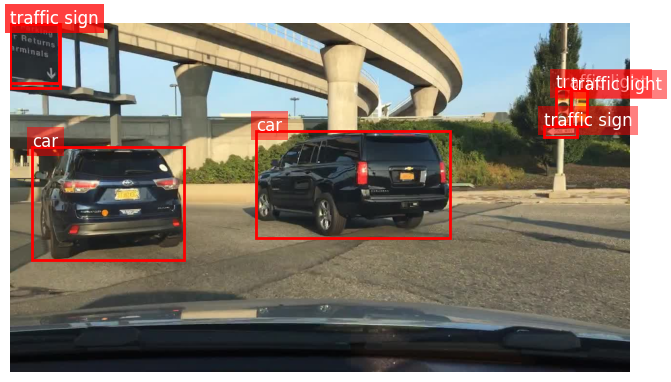

In [5]:
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np

def show_sample_with_boxes(dataset, index=0):
    """
    Retrieves `dataset[index]` and plots the image with bounding boxes + text labels.
    """
    # Get the image + target
    image_tensor, target = dataset[index]

    # Convert the image to a NumPy array if needed
    image_np = image_tensor.numpy()
    
    if image_np.shape[0] in [1, 3]:  # If (C, H, W), convert to (H, W, C)
        image_np = np.transpose(image_np, (1, 2, 0))
        image_np = image_np/256

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8,6))
    ax.imshow(image_np)
    ax.axis('off')

    boxes  = target["boxes"]
    labels = target["labels"]       # numeric IDs (optional)
    names  = target["names"]        # string labels

    # Draw bounding boxes
    for i, box in enumerate(boxes):
        # box is [x1, y1, x2, y2]
        x1, y1, x2, y2 = box.tolist()

        # Draw a rectangle
        rect = plt.Rectangle(
            (x1, y1), (x2 - x1), (y2 - y1),
            fill=False, edgecolor='red', linewidth=2
        )
        ax.add_patch(rect)

        # If you want to display the text label:
        str_label = names[i] if i < len(names) else 'unknown'
        ax.text(
            x1, y1,
            str_label,
            color='white',
            fontsize=12,
            bbox=dict(facecolor='red', alpha=0.5, edgecolor='none')
        )

    plt.show()


# Show a random sample from the training dataset
show_sample_with_boxes(dataset)